# MNIST手写体识别实验

本案例会使用MindSpore深度学习框架利用LeNet模型在MNIST数据集上实现一个简单的图片分类实验。

## 1、实验目的

（1）掌握如何使用MindSpore进行LeNet5模型的搭建

（2）了解如何使用MindSpore进行简单MNIST手写字体数据集分类任务的训练

（3）了解如何使用MindSpore进行简单MNIST手写字体数据集分类任务的测试


## 2、LeNet原理介绍

LeNet是最早发布的卷积神经网络之一，因在计算机视觉任务中的高效性能而受到广泛关注。 这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的，目的是识别图像中的手写数字。 当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究([LeCun etal.,1998](http://www.dengfanxin.cn/wp-content/uploads/2016/03/1998Lecun.pdf))，这项工作代表了十多年来神经网络研究开发的成果。

LeNet网络不包括输入层的情况下，共有7层：2个卷积层、2个下采样层（池化层）、3个全连接层。每层都包含不同数量的训练参数，如下图所示：


 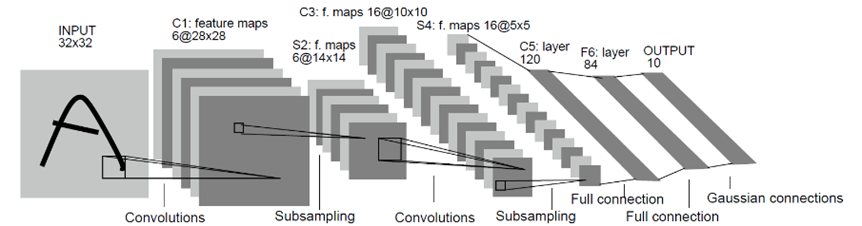
 
更多的LeNet网络的介绍不在此赘述，希望详细了解LeNet网络，可以查询http://yann.lecun.com/exdb/lenet/ 。


# 3、实验环境

本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。

在动手进行实践之前，确保您已经正确安装了MindSpore。不同平台下的环境准备请参考《MindSpore环境搭建实验手册》。

# 4、数据处理

## 4.1数据准备

我们示例中用到的MNIST数据集是由10类28*28的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。

	MNIST数据集下载地址："https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip" 。 

	将数据集下载并解压到本地路径下，这里将数据集解压分别存放到工作区的./MNIST_Data/train、./MNIST_Data/test路径下。

目录结构如下：

└─MNIST_Data

    ├─  test
    │      t10k-images.idx3-ubyte
    │      t10k-labels.idx1-ubyte
    │
    └─  train
            train-images.idx3-ubyte       
            train-labels.idx1-ubyte


In [1]:
from download import download

# 下载MNIST数据集
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:08<00:00, 1.34MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


## 4.2数据处理

在使用前，导入需要的Python库和MindSpore模块。

详细的MindSpore模块说明，可以在MindSpore API页面中搜索查询：https://www.mindspore.cn/docs/zh-CN/master/index.html

可以通过mindspore.set_context来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mindspore as ms
from mindspore import nn
from mindspore.dataset import vision,transforms,MnistDataset
from mindspore.dataset.vision import Inter
from mindspore.common.initializer import Normal
from mindspore.train import Model

#设定运行模式为图模式，运行硬件为昇腾芯片
ms.set_context(mode=ms.GRAPH_MODE, device_target='CPU') # Ascend, CPU, GPU

利用MnistDataset方法读取mnist数据集，并整体对数据集进行处理。

读取数据集时指定训练集和测试集，并进行shuffle操作， 再进行修改图片尺寸，归一化，修改图像频道等工作。修改标签的数据类型，最后设定batch_size。

In [4]:
# 定义预处理操作的流程，整体对数据集进行处理
def datapipe(path, batch_size=32):
    image_transform = [
        vision.Resize(size=32, interpolation=Inter.LINEAR),    # Resize： 以双线性插值方式调整图像尺寸大小
        vision.Rescale(1.0 / 255.0, 0.0),                      # Rescale: 缩放图像的像素值大小，将像素值统一除255，数据类型由unit8转为float32
        vision.Normalize(mean=(0.1307,),std=(0.3081,)),       # Mormalize：将像素值归一化
        vision.HWC2CHW(),                                     # HWC2CHW：将张量格式从（height,width,channel）转换成(channel,height,width)
    ]
    label_transform = transforms.TypeCast(ms.int32)
    
    # 利用MnistDataset接口读取解压后的MNIST的训练集和测试集，并进行shuffle操作
    dataset = MnistDataset(path, shuffle=True)
    # 通过map方法对每张图片应用数据处理操作
    dataset = dataset.map(operations=image_transform, input_columns=["image"])
    # 将每个标签的数据类型转换为int32
    dataset = dataset.map(operations=label_transform, input_columns=["label"])
    # 对数据集进行分批处理；当最后一个批处理数据包含的数据条目小于batch_size时，drop_remainder表示是否将该批处理丢弃，不传递给下一个操作。默认值：False，不丢弃。
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

dataset_train = datapipe("MNIST_DATA/train")
dataset_eval = datapipe("MNIST_DATA/test")

通过如下代码读取任意一个数据内容，观察打印结果。

Batch Size/通道数/图像长/宽： (32, 1, 32, 32)
图像的标签样式： [2 0 1 4 7 7 2 6 0 1 4 8 7 7 8 0 8 4 2 9 3 0 4 4 3 7 1 8 2 5 6 6]


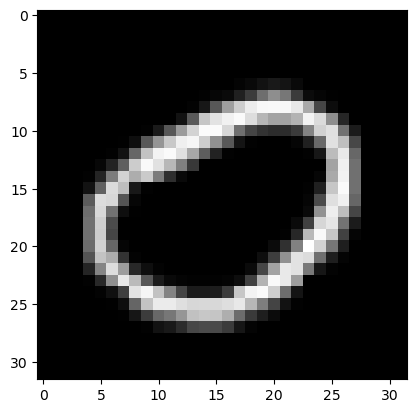

In [5]:
data_next = dataset_train.create_dict_iterator(output_numpy=True).__next__()
print('Batch Size/通道数/图像长/宽：', data_next['image'].shape)
print('图像的标签样式：', data_next['label'])

plt.figure()
plt.imshow(data_next['image'][1,...].squeeze(), cmap="gray")
plt.grid(False)
plt.show()

# 5、模型构建

使用MindSpore定义神经网络需要继承mindspore.nn.Cell。Cell是所有神经网络（Conv2d等）的基类。

神经网络的各层需要预先在__init__方法中定义，然后通过定义construct方法来完成神经网络的前向构造。原始模型激活函数为sigmoid，池化层为平均池化层。本实验采用ReLU激活函数和最大池化层，以获得更好的效果。

In [6]:
#定义模型结构，MindSpore中的模型时通过construct定义模型结构，在__init__中初始化各层的对象
class LeNet5(nn.Cell):
    """LeNet5"""

    def __init__(self, num_classes=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层，输入的通道数为num_channel,输出的通道数为6,卷积核大小为5*5
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 卷积层，输入的通道数为6，输出的通道数为16,卷积核大小为5*5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # ReLU激活函数
        self.relu = nn.ReLU()
        # 池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 多维数组展平为一维数组
        self.flatten = nn.Flatten()
        # 全连接层，输入个数为16*5*5，输出个数为120
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        # 全连接层，输入个数为120，输出个数为84
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        # 全连接层，输入个数为84，分类的个数为num_class
        self.fc3 = nn.Dense(84, num_classes, weight_init=Normal(0.02))

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 6、模型训练和测试

在进行正式的训练之前，需要对模型进行实例化，定义优化器和损失函数，首先简单介绍损失函数及优化器的概念。

损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

MindSpore支持的损失函数有SoftmaxCrossEntropyWithLogits、L1Loss、MSELoss等。这里使用SoftmaxCrossEntropyWithLogits损失函数。

训练过程中会打印loss值，类似以下代码块的运行结果所示。loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。

训练的每个epoch后都打印了模型在测试集上的测试精度，从打印的精度值分析LeNet5模型的预测能力在不断提升。

定义用于训练的train_loop函数和用于测试的test_loop函数。

使用函数式自动微分，需先定义正向函数forward_fn，使用mindspore.value_and_grad获得微分函数grad_fn。然后，我们将微分函数和优化器的执行封装为train_step函数，接下来循环迭代数据集进行训练即可。

In [7]:
# 对LeNet5进行实例化
network = LeNet5()

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 定义优化器，通过model.trainable_params()方法获得模型的可训练参数，并传入学习率超参来初始化优化器
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss

    # 定义微分函数，使用mindspore.value_and_grad获得微分函数grad_fn,输出loss和梯度。
    # 由于是对模型参数求导,grad_position 配置为None，传入可训练参数。
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

    # 定义 one-step training函数
    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, dataset_train, net_loss, net_opt)
    ms.save_checkpoint(network, "./save_direct.ckpt")
    test_loop(network, dataset_eval, net_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302583  [  0/1875]
loss: 2.289694  [100/1875]
loss: 2.299838  [200/1875]
loss: 2.307156  [300/1875]
loss: 2.301077  [400/1875]
loss: 2.323274  [500/1875]
loss: 2.306418  [600/1875]
loss: 2.293884  [700/1875]
loss: 2.309939  [800/1875]
loss: 2.275519  [900/1875]
loss: 0.659011  [1000/1875]
loss: 0.503817  [1100/1875]
loss: 0.467157  [1200/1875]
loss: 0.310772  [1300/1875]
loss: 0.132053  [1400/1875]
loss: 0.033619  [1500/1875]
loss: 0.110673  [1600/1875]
loss: 0.139349  [1700/1875]
loss: 0.103651  [1800/1875]
Test: 
 Accuracy: 96.9%, Avg loss: 0.096054 

Epoch 2
-------------------------------
loss: 0.036041  [  0/1875]
loss: 0.183115  [100/1875]
loss: 0.011907  [200/1875]
loss: 0.104491  [300/1875]
loss: 0.045409  [400/1875]
loss: 0.059863  [500/1875]
loss: 0.037797  [600/1875]
loss: 0.164139  [700/1875]
loss: 0.366695  [800/1875]
loss: 0.025931  [900/1875]
loss: 0.055179  [1000/1875]
loss: 0.001070  [1100/1875]
loss: 0.000926  [1200/1875

###### 预测结果可视化

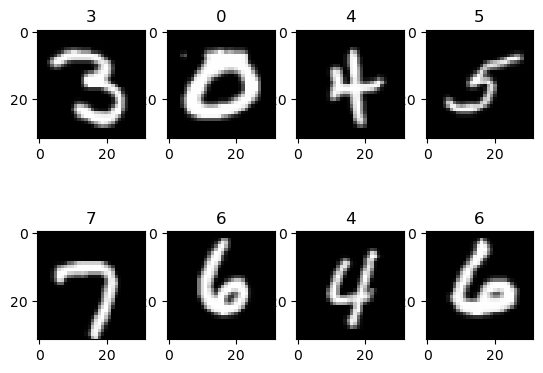

In [8]:
# 将模型参数存入parameter的字典中，采用load_checkpoint接口加载模型参数
param_dict = ms.load_checkpoint("./save_direct.ckpt")
# 重新定义一个LeNet5神经网络
net = network
# 将参数加载到网络中
ms.load_param_into_net(net, param_dict)
model = Model(net)
data_test = dataset_eval.create_dict_iterator()
data = next(data_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

# 使用函数model.predict预测image对应分类
output = model.predict(ms.Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)

plt.figure()
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(images[i-1].squeeze(), cmap="gray")
    plt.title(pred[i-1])
plt.show()